# Fast algorithm to build paths from edges (undirected)
This algorithm was built to optimise plotting graphs with pyplot (reduce number of calls by plotting paths instead of edges).\
Algorithm does not guarantee anything and resulting paths are mostly arbitrary.

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import osmnx as ox

In [2]:
def build_paths(g: nx.Graph, verbose: bool = False) -> list:
    # Converting directed to undirected graph is the most time consuming operation here
    if nx.is_directed(g):
        g = g.to_undirected()

    # Map for quick lookup of paths, keys are node_ids of either start or end of the path
    # and values are paths (same object for two keys)
    paths_ends: dict[int, list] = {}

    edges = [list(edge) for edge in g.edges(keys=False, data=False)]
    if verbose:
        print(f"Number of edges in the graph: {len(edges)}")

    loop_dropouts = []  # list of edges put aside to avoid loops

    # Try to find a place in paths_ends for each edge
    for edge in edges:
        u, v = edge

        # Check if a path exists that edge can be connected to
        path_u = paths_ends.get(u)
        path_v = paths_ends.get(v)

        # Check if adding edge to the path will create loops
        if path_u is not None and path_u is path_v:
            # If length == 2, then path is the same edge (duplicate found - ignore)
            if len(path_u) == 2:
                continue
            # Put edge aside and go to the next one
            loop_dropouts.append(edge)
            continue

        # If found two paths that can be connected with the edge - merge paths
        if path_u is not None and path_v is not None:

            # Edge connects first nodes of both paths - one has to be reversed before merging
            if path_u[0] == u and path_v[0] == v:
                path_u.reverse()  # End of path_u can be connected to beginning of path_v
            # Edge connects last nodes of both paths - one has to be reversed before merging
            if path_u[-1] == u and path_v[-1] == v:
                path_v.reverse()  # End of path_u can be connected to beginning of path_v

            # Check if end of path_u can be connected to beginning of path_v
            if path_u[-1] == u and path_v[0] == v:
                path_merged = path_u + path_v

            # Check if end of path_v can be connected to beginning of path_u
            if path_v[-1] == v and path_u[0] == u:
                path_merged = path_v + path_u

            # Clean up the path_ends map, since u and v are no longer ends of a path
            del paths_ends[u]
            del paths_ends[v]
            # Since path_merged is new object, it has to overwrite existing one in the map
            paths_ends[path_merged[0]] = path_merged
            paths_ends[path_merged[-1]] = path_merged

            # Get next edge
            continue

        # Check if a path was found that can be extended by the edge
        if path_u is not None:
            common_node = u
            other_node = v
            path = path_u

        elif path_v is not None:
            common_node = v
            other_node = u
            path = path_v

        else:
            # If no path was found - create new path with the edge
            paths_ends[u] = edge
            paths_ends[v] = edge
            continue

        # If we got this far (skipped else) it means that there is a path that has common node with the edge

        # Append new node either to the beginning or the end of the path
        if path[0] == common_node:
            path.insert(0, other_node)
        else:
            path.append(other_node)

        # Clean up path_ends map, since common_node is now inside a path and other_node is at the end of it
        del paths_ends[common_node]
        paths_ends[other_node] = path

    # Extract paths from map (fast list dedup with dictionary)
    paths = {}
    for path in paths_ends.values():
        paths[id(path)] = path
    paths = list(paths.values())

    if verbose:
        print(f"Number of reduced paths: {len(paths)}")
        print(f"Number of edges put aside to prevent loops: {len(loop_dropouts)}")

    return paths + loop_dropouts

# Test

In [3]:
# Graph to play with
DATA_PATH = "data/slovakia_borders.osm"
g = ox.graph_from_xml(DATA_PATH, retain_all=True, simplify=False)
_ = build_paths(g, verbose=True)

Number of edges in the graph: 84367
Number of reduced paths: 8
Number of edges put aside to prevent loops: 1


In [4]:
%timeit build_paths(g)

1.59 s ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Building paths from undirected graphs should be much faster
ug = g.to_undirected()
%timeit build_paths(ug)

222 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compare plotting

## osmnx

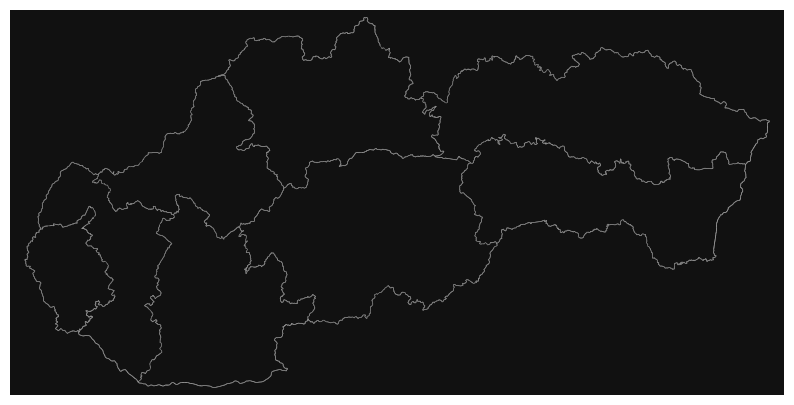

In [6]:
# NOTE: osmnx uses GeoDataFrame.plot under the hood
_ = ox.plot_graph(g, figsize=(10, 5), node_size=0, edge_linewidth=0.5, edge_alpha=1)

## Plot one edge at a time

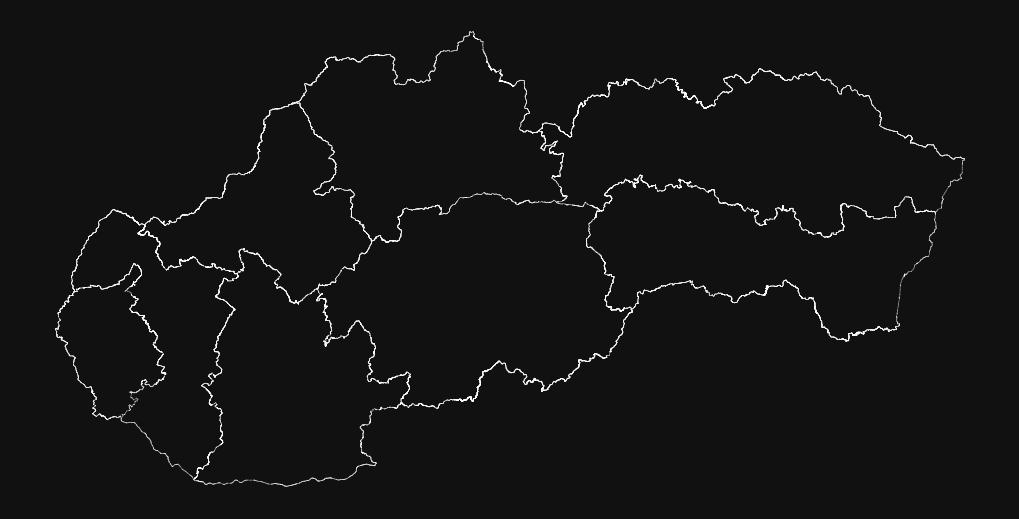

In [7]:
fig = plt.figure(figsize=(10, 5), facecolor="#111")
ax = fig.add_axes((0, 0, 1, 1))
ax.set_axis_off()

for edge in g.to_undirected().edges(data=False, keys=False):
    u_node_id, v_node_id = edge
    u_node = g.nodes[u_node_id]
    v_node = g.nodes[v_node_id]
    ux, uy = u_node["x"], u_node["y"]
    vx, vy = v_node["x"], v_node["y"]

    _ = ax.plot((ux, vx), (uy, vy), color="white", linewidth=0.5, alpha=0.5)

## Convert edges to paths before plotting

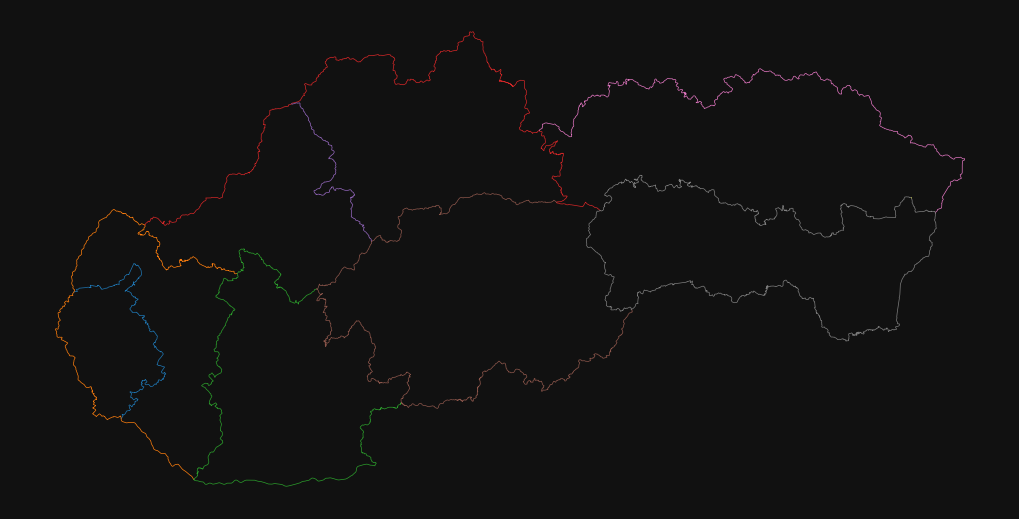

In [8]:
fig = plt.figure(figsize=(10, 5), facecolor="#111")
ax = fig.add_axes((0, 0, 1, 1))
ax.set_axis_off()

paths = build_paths(g)

for edge in paths:
    x = []
    y = []
    for node_id in edge:
        # Node osmid -> coordinates lookup
        node = g.nodes[node_id]
        x.append(node["x"])
        y.append(node["y"])
    _ = ax.plot(x, y, linewidth=0.5, alpha=1)